In [2]:
# Import libraries
import pandas as pd
import IPython.display as ipd
from matplotlib import pyplot as plt
import librosa
import librosa.display
import os
import shutil
import random
import numpy as np
from tqdm.notebook import tqdm

In [3]:
# Set seed
np.random.seed(2022)

In [4]:
# Load files
train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')

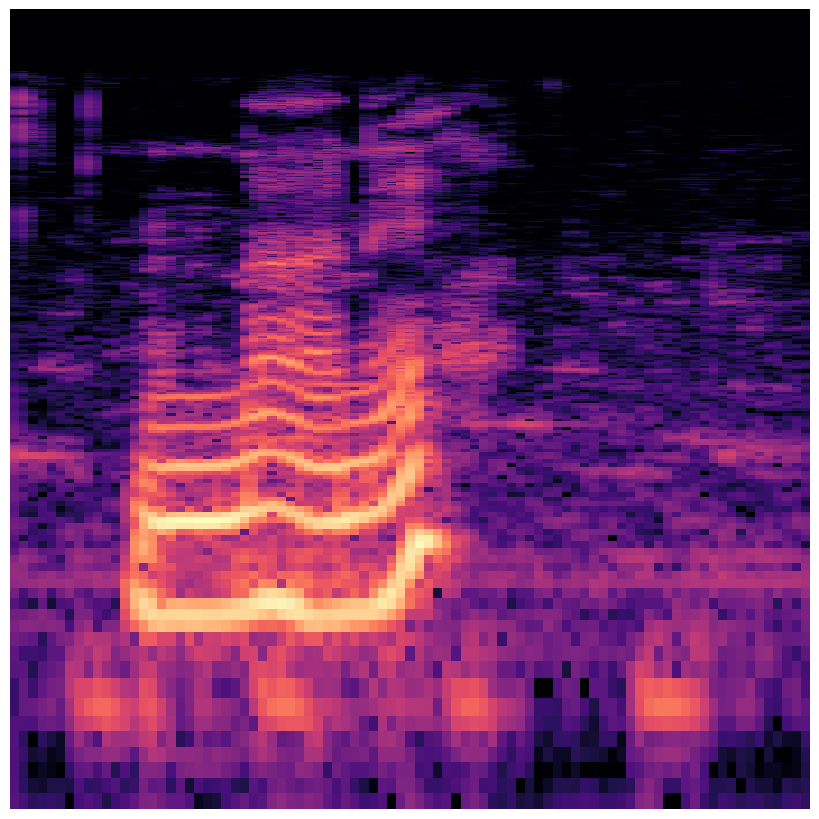

In [7]:
# Going from a sound to an image: spectrograms
# os.mkdir('data/spectrograms_centre') # Create a folder to store the spectrograms

# Function to generate spectrogram
def gen_spectrogram(path):
    x , sr = librosa.load(path)
    ind_max = x.argmax()
    x_2sec = x[ind_max-sr:ind_max+sr]
    X = librosa.stft(x_2sec)
    Xdb = librosa.amplitude_to_db(np.abs(X), ref=np.max)
    fig = plt.figure(frameon=False)
    fig.set_size_inches(8, 8)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    # plt.title('Swahili Word - Nane')
    librosa.display.specshow(Xdb, y_axis='log', x_axis='time', sr=sr)
    spec_path = 'data/spectrograms_centre/' + path.split('/')[2][:-4] +'.png'
    fig.savefig(spec_path, dpi=512//8)

gen_spectrogram('data/Swahili_words/id_pwvzavl2dl6q.wav')
display(ipd.Audio('data/Swahili_words/id_pwvzavl2dl6q.wav'))


# show the three files of each word time-centered in frequency domain
# for word in dict_samples:
#     i=0
#     fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)
#     fig.set_size_inches(10, 5)
#     fig.suptitle(word)
#     for audiofile in dict_samples[word]:
#         x, sr = librosa.load('data/Swahili_words/'+audiofile)
#         # filtering +-1sec around the loudest part, centering the wavefiles to spoken word 
#         ind_max = x.argmax()
#         x_2sec = x[ind_max-sr:ind_max+sr]
#         X = librosa.amplitude_to_db(np.abs(librosa.stft(x_2sec)), ref=np.max)
#         img = librosa.display.specshow(X, y_axis='log', x_axis='time', sr=sr, ax=ax[i])
#         i+=1

In [8]:
# Concatenate train with test for easy data manipulation
train_test_files = train.Word_id.tolist() + test.Word_id.tolist()

for word_id in tqdm(train_test_files):
  # Check if we've already generated a spectrogram, and if not, make one
    spec_path = 'data/spectrograms_centre/' + word_id[:-4] +'.png'
    if not os.path.isfile(spec_path):
        plt.clf()
        gen_spectrogram('data/Swahili_words/'+ word_id)
    ipd.clear_output(wait=True)
    plt.close()

<Figure size 640x480 with 0 Axes>

In [9]:
# Checking that the spectrograms were generated successfully:
len(os.listdir('data/Swahili_words')) == len(os.listdir('data/spectrograms_centre')), len(os.listdir('data/spectrograms_centre'))

(True, 6000)

In [10]:
# Add spectrogram path to train set
train['spec_name'] = [x.split('.')[0] + '.png' for x in train.Word_id]

# Preview train
train.head()

,Word_id,Swahili_word,English_translation,spec_name
0,id_v8rz06e6rv31.wav,mbili,two,id_v8rz06e6rv31.png
1,id_vmbwicdpfn68.wav,tatu,three,id_vmbwicdpfn68.png
2,id_injlouhxg1hg.wav,ndio,yes,id_injlouhxg1hg.png
3,id_gdq23p6xgzya.wav,nne,four,id_gdq23p6xgzya.png
4,id_lpstklz51zpz.wav,nane,eight,id_lpstklz51zpz.png


In [11]:
from fastai.vision.all import *

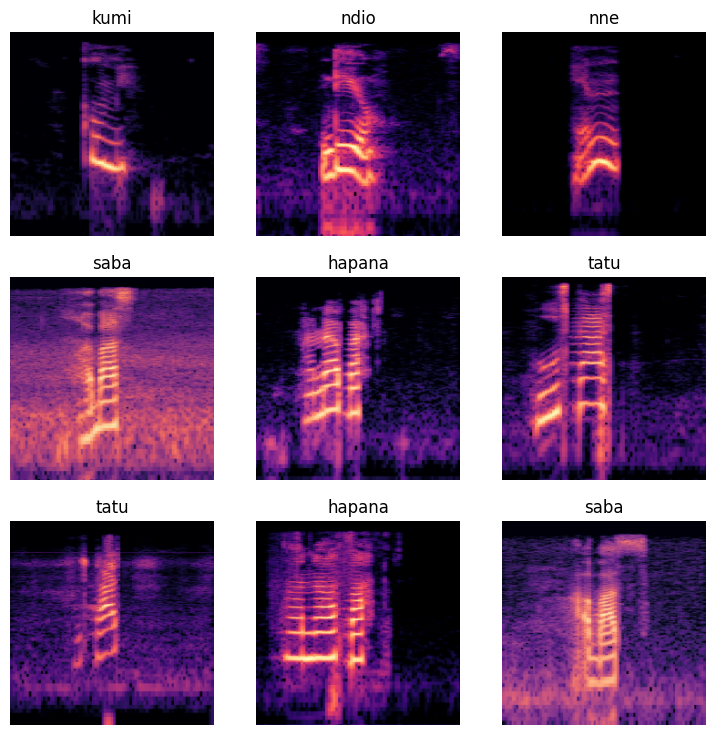

In [14]:
# Create the dataloaders
dls = ImageDataLoaders.from_df(train, fn_col='spec_name', label_col='Swahili_word', 
                               folder='data/spectrograms_centre', item_tfms=Resize(400),
                               batch_tfms = aug_transforms(max_rotate=0, max_warp=0, size=224))
dls.show_batch() # Note the augmentation applied to the images!

In [15]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

/home/maike_und_daniel/Dokumente/Python-Projekte/Swahili_Audio_Classification/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/maike_und_daniel/Dokumente/Python-Projekte/Swahili_Audio_Classification/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.948348,1.616333,0.514286,06:14


epoch,train_loss,valid_loss,error_rate,time
0,1.489218,0.840867,0.264286,09:15
1,0.944623,0.596894,0.169048,09:18
2,0.615515,0.428951,0.132143,09:13
3,0.424185,0.402708,0.122619,09:20


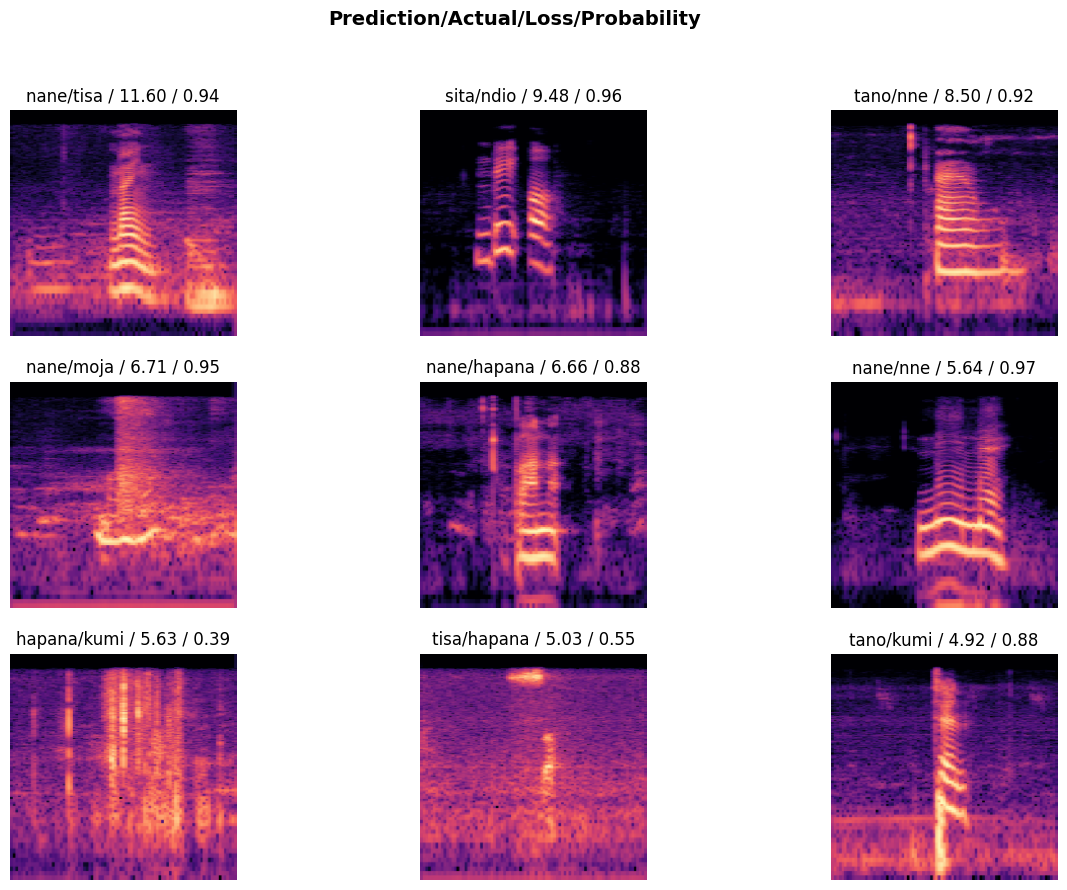

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

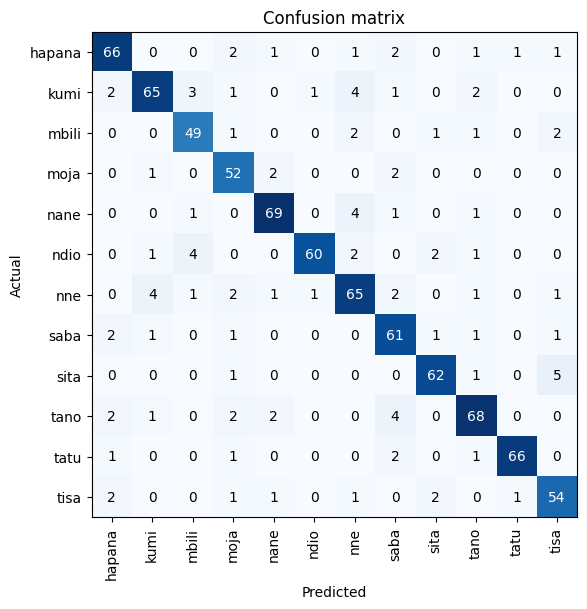

In [17]:
interp.plot_confusion_matrix(figsize=(6,6))

In [20]:
test = pd.read_csv('data/Test.csv')
test['spec_name'] = [x.split('.')[0] + '.png' for x in test['Word_id']]

preds, _ = learn.get_preds(dl=dls.test_dl(test)) 
preds.shape

torch.Size([1800, 12])

In [21]:
learn.dls.vocab # The labels in the order used by the model (alphabetical)

['hapana', 'kumi', 'mbili', 'moja', 'nane', 'ndio', 'nne', 'saba', 'sita', 'tano', 'tatu', 'tisa']

In [22]:
submission = pd.DataFrame({'Word_id': test['Word_id']})
for i, label in enumerate(learn.dls.vocab):
    submission[label] = preds[:,i].numpy()
submission.head()

,Word_id,hapana,kumi,mbili,moja,nane,ndio,nne,saba,sita,tano,tatu,tisa
0,id_jp2pxl0r84ya.wav,9.115642e-08,1.215230e-08,3.969100e-06,3.933233e-07,9.492680e-08,4.600179e-07,4.700273e-07,4.503991e-07,9.999434e-01,8.447208e-10,2.019241e-06,4.857697e-05
1,id_ndduqqvthbpx.wav,3.588680e-09,1.090985e-08,1.334545e-08,8.153267e-10,7.163133e-11,1.679898e-07,1.276366e-08,2.645336e-08,1.094369e-05,1.808562e-08,1.249283e-06,9.999875e-01
2,id_36oxymxfcm6q.wav,4.476158e-08,1.762789e-05,1.013061e-03,1.372794e-08,2.919629e-07,2.142264e-04,5.074572e-06,2.602451e-04,3.335282e-05,9.586055e-06,4.655798e-07,9.984462e-01
3,id_ue9b0to760pg.wav,4.295467e-05,3.684933e-05,1.168784e-07,5.763671e-08,7.562961e-05,1.925428e-07,1.361882e-06,7.713134e-05,6.610625e-09,9.997134e-01,5.230204e-05,3.063101e-08
4,id_prja4oprb914.wav,1.842162e-06,1.368380e-05,2.654522e-05,2.225293e-04,9.987707e-01,1.581124e-05,8.837122e-04,3.486931e-07,1.208505e-07,6.357363e-05,3.365786e-07,8.864909e-07


In [23]:
submission.to_csv('data/submission_centre.csv', index=False)